## Goal-- build a packages on top of fastai for extra loss functions

In [1]:
import torch
from fastai.data.all import *
from fastai.vision.all import *
from patchify import patchify
from PIL import Image
import optuna
from optuna.integration import FastAIPruningCallback
import optuna.visualization as vs
#import monai.losses as mloss

#from odyssey_losses.dice_loss import TverskyLoss

In [2]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

def get_learner(loss_func):
    learn = unet_learner(dls, resnet34, loss_func = loss_func, metrics=DiceMulti(axis=1))
    lr = learn.lr_find()[0]
    return learn, lr

In [3]:
class DiceFocalLoss: # example class building on dice loss
    "Dice and Focal Loss combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth, reduction="mean")
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)
    # This works because fastai yoinks it using getcallable, a wrapper for getattr
    # only the definition inside the outer class actually used matters!

In [4]:
class DiceCELoss: 
    "Dice and Focal Loss combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.ce_loss = CrossEntropyLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth, reduction="mean")
        
    def __call__(self, pred, targ):
        return self.ce_loss(pred, targ) + self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [5]:
class SimpleDice:
    "Just a wrapper over dice loss for testing purposes."
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.dice_loss =  DiceLoss(axis, smooth, reduction="mean")
        
    def __call__(self, pred, targ):
        return self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)


In [6]:
class LogCoshDiceLoss:
    "proposed in http://arxiv.org/abs/2006.14822"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.dice_loss =  DiceLoss(axis, smooth, reduction="sum") # sum won't even work. Interesting.
        
    def __call__(self, pred, targ):
        x = self.dice_loss(pred, targ)
        #return torch.log(torch.cosh(x)) #something wrong with this implementation...
        return torch.log((torch.exp(x) + torch.exp(-x)) / 2.0) # pretty much the same problem. Something screwy with the activation perhaps...
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)
    #def activation(self, x): return x # no activation??

### !!! The model has NO softmax !!! You must provide your own in the loss fn

## THE LOSS. NEEDS. TO. BE. FLATTENED.

### Alternative: abandon fastai loss classes entirely, instead relying on functions.

In [7]:
DiceLoss?

Init signature:
DiceLoss(
    axis: 'int' = 1,
    smooth: 'float' = 1e-06,
    reduction: 'str' = 'sum',
    square_in_union: 'bool' = False,
)
Docstring:      Dice loss for segmentation
File:           ~/.pyenv/versions/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/losses.py
Type:           type
Subclasses:     

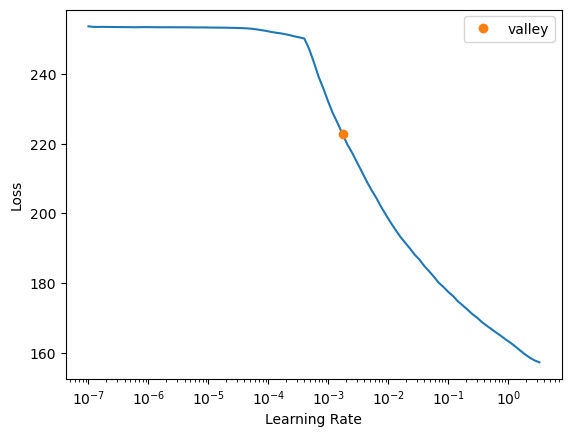

In [8]:
#loss_func = DiceFocalLoss()
#loss_func = BaseLoss(DiceLoss, axis=1, smooth=1, reduction="mean")#, square_in_union=True) #dice loss is naturally unsmooth
loss_func = DiceLoss() #dice loss is naturally unsmooth

#loss_func = CrossEntropyLossFlat(axis=1)
#loss_func = SimpleDice()
#loss_func = DiceCELoss()
#loss_func = LogCoshDiceLoss()
learn, lr = get_learner(loss_func)

epoch,train_loss,valid_loss,dice_multi,time
0,206.675491,113.060135,0.016029,00:01


epoch,train_loss,valid_loss,dice_multi,time
0,123.438820,113.060135,0.016029,00:01
1,123.516426,113.060135,0.016029,00:01
2,123.529465,113.060135,0.016029,00:01
3,123.480774,113.060135,0.016029,00:01
4,123.515022,113.060135,0.016029,00:01
5,123.506401,113.060135,0.016029,00:01
6,123.448074,113.060135,0.016029,00:01
7,123.434250,113.060135,0.016029,00:01


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

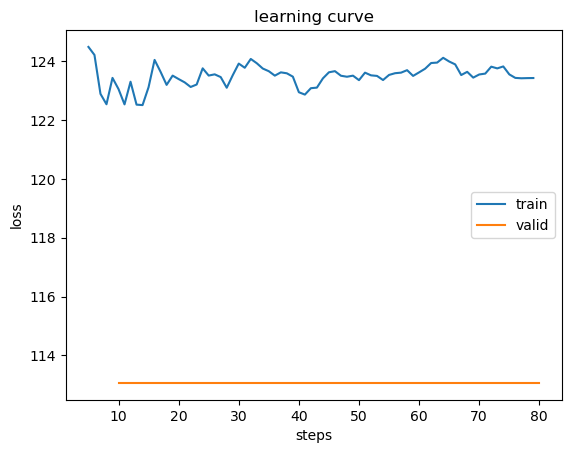

In [9]:
learn.fine_tune(8, lr)
learn.recorder.plot_loss()

In [10]:
# interesting. SimpleDice has the same problem it seems. I thought it worked??
# OK. now regular dice won't work??
# what does the jagged train loss, perfectly flat valid loss mean? Is there no back-propogation??

# ce works fine. Some kind of shape problem??